# Simple Linear Classifier
--------------------------------------------
## This model can classify image of number 3 or number 7 from MNIST database

In [33]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [34]:
from fastai.vision.all import *
from fastbook import *

Getting images from MNIST

In [35]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('labels.csv'),Path('valid')]

In [36]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Stack all images of 3 in trainning set on top of each other, and do the same for 7 and images in valid set

In [37]:
stacked_threes = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'3').ls()])
stacked_threes = stacked_threes.float()/255

stacked_sevens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'7').ls()])
stacked_sevens = stacked_threes.float()/255
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6131, 28, 28]))

In [38]:
valid_threes = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_threes = valid_threes.float()/255

valid_sevens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_sevens = valid_threes.float()/255
valid_threes.shape, valid_sevens.shape

(torch.Size([1010, 28, 28]), torch.Size([1010, 28, 28]))

Now, we create our independent variables `X`. These are all images in our trainning set, and they also will be changed from rank-3 tensor to rank-2 tensor.
We also need label for our images. Number `1` will represent for 3s and `0` will be for 7s 

In [39]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12262, 784]), torch.Size([12396, 1]))

Group train_x and train_y into a tuple of (x,y) to have a `Dataset`

In [40]:
dset = list(zip(train_x, train_y))

We will do the same for `valid set`

In [41]:
valid_x = torch.cat([valid_threes, valid_sevens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_threes) + [0]*len(valid_sevens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need to initilize random weight for every pixel

In [42]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

linear1 will return predictions by using matrix multiplication

In [43]:
def linear1(xb): return xb@weights + bias

This is our loss function which measures the distance between `predictions` and `targets`  
*The sigmoid function is a function that always outputs a number between 0 and 1*

In [44]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

This is a function that calculates the gradient

In [45]:
def calc_grad(xb,yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

train_epoch will calculate gradients and also update parameters

In [46]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()      

This will calculate our validation accuracy

In [47]:
def batch_accuracy(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb 
    #if preds is greater than 0.5 it means the prediction is number 3
    return correct.float().mean()

Then this will do the job for the whole batch

In [48]:
def validate_epoch(model):
    accuracies = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accuracies).mean().item(), 4)

## Execution Phase
------------------------------
### The most basic way

First we initialize our parameters:

In [49]:
weights = init_params((28*28,1))
bias = init_params(1)

Using `Dataloader` to create mini-batches from our `Dataset` 

In [50]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [51]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Okay! let's train for one epoch

In [52]:
lr  = 1 #we set learning rate to 1
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.9907

let's train it few more time

In [53]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.9956 0.9985 0.999 0.9995 0.9995 0.9995 0.9995 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

### the second trial(including Optimizer)

Some additional functions and classes

This is our `Optimizer class` which will help us handle `parameter` and `lr`, as well as calculating `gradient` 

In [54]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
    
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
            

let's update `train_epoch` method using `Optimizer` now

In [55]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

We also wanna have a method to train our model in many epochs

In [56]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

First we subtitute our simple funtion(linear1) for Pytorch's nn.Linear module. (*from the PyTorch nn.Module class*)

In [57]:
linear_model = nn.Linear(28*28,1)

We can get parameters from PyTorch module by using `paramters` method

In [58]:
w,b = linear_model.parameters()
w.shape,b.shape #(weights and biasis)

(torch.Size([1, 784]), torch.Size([1]))

In [59]:
opt = BasicOptim(linear_model.parameters(), lr)

In [60]:
validate_epoch(linear_model)

0.8296

In [61]:
train_model(linear_model, 20)

1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

Or We can also use `SGD` class from fastai in exchange for `BasicOptim` 

In [62]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

### Using pre-built functions and classes from fastai

In [63]:
#we need to create a DataLoaders, by passing in our training and validation DataLoaders
dls = DataLoaders(dl, valid_dl)
#learner(dataloaders, initial parameter, optimizer or SGD, loss function, metrics)
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
#fastai also provides Learner.fit, which we can use instead of train_model.
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.115182,0.027901,1.000000,00:00
1,0.048163,0.013874,1.000000,00:00
2,0.025283,0.009372,1.000000,00:00
3,0.015278,0.007104,1.000000,00:00
4,0.010348,0.005737,1.000000,00:00
5,0.007682,0.004821,1.000000,00:00
6,0.006105,0.004165,1.000000,00:00
7,0.005088,0.003670,1.000000,00:00
8,0.004382,0.003284,1.000000,00:00
9,0.003860,0.002974,1.000000,00:00


### Using Nonlinearity(optional)

Instead of using `single linear layer`, we try to add one more linear layer to our architecture(model) with a `nonlinearity` in between.  
`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

In [64]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [65]:
learn = Learner(dls, simple_net, opt_func=SGD,
               loss_func=mnist_loss, metrics=batch_accuracy)

In [66]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.335540,0.210051,1.000000,00:00
1,0.243253,0.140759,1.000000,00:00
2,0.176641,0.095939,1.000000,00:00
3,0.126424,0.066544,1.000000,00:00
4,0.090038,0.047311,1.000000,00:00
5,0.064576,0.034651,1.000000,00:00
6,0.047110,0.026194,1.000000,00:00
7,0.035192,0.020413,1.000000,00:00
8,0.027001,0.016352,1.000000,00:00
9,0.021280,0.013417,1.000000,00:00


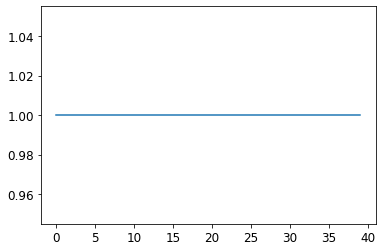

In [67]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [68]:
learn.recorder.values[-1][2]

1.0

### Pre-trained Model

In [69]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                   loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.118732,0.033004,0.991659,00:14
